Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter your name: Vishwak
Enter your age: 17

Hello Vishwak, analyzing your emotional state...


<IPython.core.display.Javascript object>

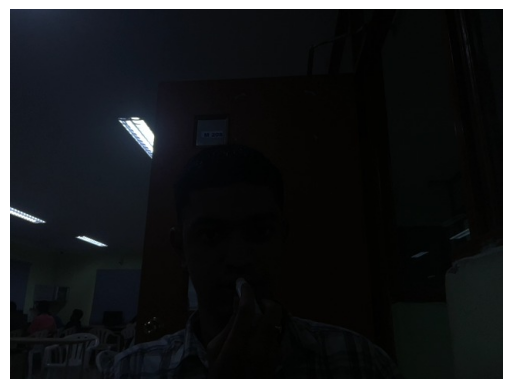


Emotion Analysis Result: {
    "polarity": "NEUTRAL",
    "confidence": null,
    "concerns": []
}
Output saved to output.json

Final Mental Health Analysis: {
    "polarity": "POSITIVE",
    "confidence": 0.7481208443641663,
    "concerns": []
}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting mental health concern analysis...
Press 's' to capture and process the image, or 'q' to quit.
No text captured from camera.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Polarity: NEGATIVE (Confidence: 0.9992185831069946)

Final Determined Issues:
Polarity: NEGATIVE (Confidence: 0.9992185831069946)
Identified Concern: 'anxious' classified as: Anxiety
Identified Concern: 'extremely anxious' classified as: Anxiety
Identified Concern: 'trouble sleeping' classified as: Anxiety
Output saved to output.json

Structured Output: {'polarity': 'NEGATIVE', 'confidence': 0.9992185831069946, 'concerns': [{'concern': 'anxious', 'category': 'Anxiety'}, {'concern': 'extremely anxious', 'category': 'Anxiety'}, {'concern': 'trouble sleeping', 'category': 'Anxiety'}]}


In [3]:
# Install pytesseract
!pip install pytesseract

# Install Tesseract OCR
!apt-get install -y tesseract-ocr

!pip install fer



import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from fer import FER  # Facial Expression Recognition
from IPython.display import Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import spacy

# Initialize models
emotion_detector = FER()
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
nlp_ner = spacy.load("en_core_web_sm")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model_classifier = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Custom keywords for mapping concerns
custom_concerns = {
    "anxiety": ["anxious", "extremely anxious", "worried", "nervous"],
    "depression": ["depressed", "very low", "down", "hopeless"],
    "insomnia": ["trouble sleeping", "insomnia", "can't sleep", "sleepless"],
    "stress": ["stressed", "under pressure", "overwhelmed"]
}

def capture_image():
    """
    Capture an image from the webcam.
    """
    js = """
    async function takePhoto() {
      const video = document.createElement('video');
      video.style.display = 'none';
      document.body.appendChild(video);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      stream.getTracks().forEach(track => track.stop());
      video.remove();

      return canvas.toDataURL('image/jpeg');
    }
    takePhoto();
    """
    display(Javascript(js))
    data = eval_js("takePhoto()")
    header, encoded = data.split(",", 1)
    img_data = b64decode(encoded)
    img_np = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
    return img

def analyze_emotion(img):
    """
    Analyze the emotion from the captured image using FER.
    """
    result = emotion_detector.top_emotion(img)
    if result is None:
        print("No faces detected.")
        return None

    emotion, confidence = result
    concerns = []
    if emotion == "sad":
        concerns.append({"concern": "feeling very low", "category": "Depression", "intensity": 7})
    elif emotion == "angry":
        concerns.append({"concern": "feeling irritable", "category": "Stress", "intensity": 6})
    elif emotion == "fearful":
        concerns.append({"concern": "feeling extremely anxious", "category": "Anxiety", "intensity": 8})
    elif emotion == "neutral":
        concerns.append({"concern": "lack of enthusiasm", "category": "Mild Depression", "intensity": 4})

    output = {
        "polarity": "NEGATIVE" if emotion in ["sad", "angry", "fearful"] else "NEUTRAL",
        "confidence": confidence,
        "concerns": concerns
    }
    return output

def extract_concerns(text, doc):
    """
    Extract concerns from detected text using NER and custom keywords.
    """
    extracted_concerns = [ent.text for ent in doc.ents if ent.label_ in ["ANXIETY", "DEPRESSION", "STRESS", "INSOMNIA"]]
    for category, phrases in custom_concerns.items():
        for phrase in phrases:
            if phrase in text:
                extracted_concerns.append(phrase)
    return extracted_concerns

def determine_mental_health_issue(text, save_to_file=False):
    """
    Determine mental health concerns based on extracted text.
    """
    output = {"polarity": None, "confidence": None, "concerns": []}

    # Polarity Detection
    polarity_result = sentiment_analyzer(text)[0]
    output["polarity"] = polarity_result['label']
    output["confidence"] = polarity_result['score']

    # Concern Classification
    doc = nlp_ner(text)
    extracted_concerns = extract_concerns(text, doc)
    for concern in extracted_concerns:
        inputs = tokenizer(concern, return_tensors="pt")
        outputs = model_classifier(**inputs)
        label = outputs.logits.argmax().item()
        categories = ["Anxiety", "Depression", "Stress", "Insomnia", "Eating Disorder"]
        classified_concern = categories[label]
        output["concerns"].append({"concern": concern, "category": classified_concern})

    if save_to_file:
        with open("output.json", "w") as outfile:
            json.dump(output, outfile, indent=4)
        print("Output saved to output.json")

    return output

def main():
    """
    Main function to capture name, age, image, and perform analysis.
    """
    # Capture user details
    user_name = input("Enter your name: ")
    user_age = input("Enter your age: ")

    print(f"\nHello {user_name}, analyzing your emotional state...")

    # Capture image
    img = capture_image()

    if img is not None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

        # Analyze emotion from image
        emotion_output = analyze_emotion(img)
        print("\nEmotion Analysis Result:", json.dumps(emotion_output, indent=4))

        # Determine mental health based on extracted text from concerns
        if emotion_output:
            detected_concerns = " ".join([c["concern"] for c in emotion_output["concerns"]])
            mental_health_output = determine_mental_health_issue(detected_concerns, save_to_file=True)
            print("\nFinal Mental Health Analysis:", json.dumps(mental_health_output, indent=4))
        else:
            print("Emotion analysis could not be performed.")
    else:
        print("No image captured from camera.")

# Run the main function
main()
import spacy
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import json
import cv2
import pytesseract  # Tesseract OCR library

# Initialize models
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
nlp_ner = spacy.load("en_core_web_sm")  # Load SpaCy model for NER, assuming it’s fine-tuned for mental health
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model_classifier = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Custom keywords for mental health-related concerns
custom_concerns = {
    "anxiety": ["anxious", "extremely anxious", "worried", "nervous"],
    "depression": ["depressed", "very low", "down", "hopeless"],
    "insomnia": ["trouble sleeping", "insomnia", "can't sleep", "sleepless"],
    "stress": ["stressed", "under pressure", "overwhelmed"]
}

def capture_text_from_camera():
    # Start video capture
    cap = cv2.VideoCapture(0)
    print("Press 's' to capture and process the image, or 'q' to quit.")

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            cv2.imshow('Camera', frame)
            if cv2.waitKey(1) & 0xFF == ord('s'):
                # Save and process image on pressing 's'
                captured_text = process_image_with_ocr(frame)
                print(f"Captured Text: {captured_text}")
                cap.release()
                cv2.destroyAllWindows()
                return captured_text
            elif cv2.waitKey(1) & 0xFF == ord('q'):
                # Quit on pressing 'q'
                cap.release()
                cv2.destroyAllWindows()
                return None
        else:
            break

def process_image_with_ocr(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Perform OCR on the image
    text = pytesseract.image_to_string(gray)
    return text.strip()

def extract_concerns(text, doc):
    extracted_concerns = [ent.text for ent in doc.ents if ent.label_ in ["ANXIETY", "DEPRESSION", "STRESS", "INSOMNIA"]]

    # Check for custom keyword matches
    for category, phrases in custom_concerns.items():
        for phrase in phrases:
            if phrase in text:
                extracted_concerns.append(phrase)

    return extracted_concerns

# Define the function
def determine_mental_health_issue(text, save_to_file=False):
    # Initialize the output structure
    output = {"polarity": None, "confidence": None, "concerns": []}

    # Step 1: Polarity Detection
    polarity_result = sentiment_analyzer(text)[0]
    output["polarity"] = polarity_result['label']
    output["confidence"] = polarity_result['score']
    print(f"Polarity: {output['polarity']} (Confidence: {output['confidence']})")

    # Step 2: Keyword Extraction (NER and Custom Keywords)
    doc = nlp_ner(text)
    extracted_concerns = extract_concerns(text, doc)

    # If no relevant concerns found
    if not extracted_concerns:
        return "No specific mental health concerns detected."

    # Step 3: Concern Classification
    for concern in extracted_concerns:
        inputs = tokenizer(concern, return_tensors="pt")
        outputs = model_classifier(**inputs)
        label = outputs.logits.argmax().item()

        # Map label to category name based on training labels
        categories = ["Anxiety", "Depression", "Stress", "Insomnia", "Eating Disorder"]
        classified_concern = categories[label]
        output["concerns"].append({"concern": concern, "category": classified_concern})

    # Structured final output
    print("\nFinal Determined Issues:")
    print(f"Polarity: {output['polarity']} (Confidence: {output['confidence']})")
    for item in output["concerns"]:
        print(f"Identified Concern: '{item['concern']}' classified as: {item['category']}")

    # Optionally save the output to a JSON file
    if save_to_file:
        with open("output.json", "w") as outfile:
            json.dump(output, outfile, indent=4)
        print("Output saved to output.json")

    return output

# Main function to capture text and analyze it
def main():
    print("Starting mental health concern analysis...")
    user_text = capture_text_from_camera()
    if user_text:
        result = determine_mental_health_issue(user_text, save_to_file=True)
        print("\nStructured Output:", result)
    else:
        print("No text captured from camera.")

# Run the main function
main()
import spacy
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import json

# Initialize models
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
nlp_ner = spacy.load("en_core_web_sm")  # Load SpaCy model for NER, assuming it’s fine-tuned for mental health
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model_classifier = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Custom keywords for mental health-related concerns
custom_concerns = {
    "anxiety": ["anxious", "extremely anxious", "worried", "nervous"],
    "depression": ["depressed", "very low", "down", "hopeless"],
    "insomnia": ["trouble sleeping", "insomnia", "can't sleep", "sleepless"],
    "stress": ["stressed", "under pressure", "overwhelmed"]
}

def extract_concerns(text, doc):
    extracted_concerns = [ent.text for ent in doc.ents if ent.label_ in ["ANXIETY", "DEPRESSION", "STRESS", "INSOMNIA"]]

    # Check for custom keyword matches
    for category, phrases in custom_concerns.items():
        for phrase in phrases:
            if phrase in text:
                extracted_concerns.append(phrase)

    return extracted_concerns

# Define the function
def determine_mental_health_issue(text, save_to_file=False):
    # Initialize the output structure
    output = {"polarity": None, "confidence": None, "concerns": []}

    # Step 1: Polarity Detection
    polarity_result = sentiment_analyzer(text)[0]
    output["polarity"] = polarity_result['label']
    output["confidence"] = polarity_result['score']
    print(f"Polarity: {output['polarity']} (Confidence: {output['confidence']})")

    # Step 2: Keyword Extraction (NER and Custom Keywords)
    doc = nlp_ner(text)
    extracted_concerns = extract_concerns(text, doc)

    # If no relevant concerns found
    if not extracted_concerns:
        return "No specific mental health concerns detected."

    # Step 3: Concern Classification
    for concern in extracted_concerns:
        inputs = tokenizer(concern, return_tensors="pt")
        outputs = model_classifier(**inputs)
        label = outputs.logits.argmax().item()

        # Map label to category name based on training labels
        categories = ["Anxiety", "Depression", "Stress", "Insomnia", "Eating Disorder"]
        classified_concern = categories[label]
        output["concerns"].append({"concern": concern, "category": classified_concern})

    # Structured final output
    print("\nFinal Determined Issues:")
    print(f"Polarity: {output['polarity']} (Confidence: {output['confidence']})")
    for item in output["concerns"]:
        print(f"Identified Concern: '{item['concern']}' classified as: {item['category']}")

    # Optionally save the output to a JSON file
    if save_to_file:
        with open("output.json", "w") as outfile:
            json.dump(output, outfile, indent=4)
        print("Output saved to output.json")

    return output

# Example usage
user_input = "I feel extremely anxious and have trouble sleeping."
result = determine_mental_health_issue(user_input, save_to_file=True)
print("\nStructured Output:", result)